# Search and Load CMIP6 Data via ESGF / OPeNDAP

This notebooks shows how to search and load data via [Earth System Grid Federation](https://esgf.llnl.gov/) infrastructure. This infrastructure works great and is the foundation of the CMIP6 distribution system.

The main technologies used here are the [ESGF search API](https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API), used to figure out what data we want, and [OPeNDAP](https://www.opendap.org/), a remote data access protocol over HTTP.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cftime
import cmaps
import cartopy.crs as ccrs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

### Search using ESGF API

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [3]:
result = esgf_search(activity_id='CMIP', variable_id='mmroa',
                  institution_id="NCC", source_id='NorESM2-LM', experiment_id='abrupt-4xCO2')
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=mmroa&institution_id=NCC&source_id=NorESM2-LM&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=mmroa&institution_id=NCC&source_id=NorESM2-LM&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=mmroa&institution_id=NCC&source_id=NorESM2-LM&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=mmroa&institution_id=NCC&source_id=NorESM2-LM&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=mmroa&inst

['http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCC/NorESM2-LM/abrupt-4xCO2/r1i1p1f1/AERmon/mmroa/gn/v20190815/mmroa_AERmon_NorESM2-LM_abrupt-4xCO2_r1i1p1f1_gn_000101-001012.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCC/NorESM2-LM/abrupt-4xCO2/r1i1p1f1/AERmon/mmroa/gn/v20190815/mmroa_AERmon_NorESM2-LM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCC/NorESM2-LM/abrupt-4xCO2/r1i1p1f1/AERmon/mmroa/gn/v20190815/mmroa_AERmon_NorESM2-LM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCC/NorESM2-LM/abrupt-4xCO2/r1i1p1f1/AERmon/mmroa/gn/v20190815/mmroa_AERmon_NorESM2-LM_abrupt-4xCO2_r1i1p1f1_gn_003101-004012.nc',
 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCC/NorESM2-LM/abrupt-4xCO2/r1i1p1f1/AERmon/mmroa/gn/v20190815/mmroa_AERmon_NorESM2-LM_abrupt-4xCO2_r1i1p1f1_gn_004101-005012.nc',
 'http://esgf-data1.

In [4]:
# pick one file for testing
files_to_open = [result[-1]]


### Load Data with Xarray

These are OPeNDAP endpoints. Xarray, together with the netCDF4 python library, allow lazy loading.

In [5]:

ds = xr.open_mfdataset(files_to_open, combine='by_coords')
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lev: 32, lon: 144, time: 120)
Coordinates:
  * time       (time) object 0491-01-16 12:00:00 ... 0500-12-16 12:00:00
  * lev        (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
    p0         float64 ...
    a          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    a_bnds     (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(120, 96, 144), meta=np.ndarray>
    mmroa      (time, lev, lat, lon) float32 dask.array<chunksize=(120, 32, 96, 144), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   Hybrid-restart from year 1600-01-01 of p...
    branch_time:                     0.0
    branch_time_in_child:            0.0
    branch_time_in_parent:           430335.0
    ...                              ...
    variable_id:                     mmroa
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by NCC is lice...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/7e00d8c9-0c7f-40fc-911b-6f7...
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
ds.mmroa

<xarray.DataArray 'mmroa' (time: 120, lev: 32, lat: 96, lon: 144)>
dask.array<open_dataset-d0504567ed5e2e669614a36f6263cfeammroa, shape=(120, 32, 96, 144), dtype=float32, chunksize=(120, 32, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0491-01-16 12:00:00 ... 0500-12-16 12:00:00
  * lev      (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:   mass_fraction_of_particulate_organic_matter_dry_aerosol_...
    long_name:       Total Organic Aerosol Mass Mixing Ratio
    comment:         We recommend a scale factor of POM=1.4*OC, unless your m...
    units:           kg kg-1
    original_name:   mmr_OM
    original_units:  kg/kg
    history:         2019-12-11T13:14:22Z altered by CMOR: Converted units fr...
    cell_methods:    area: time: mean
    cell_measures:   area: areacella
    _ChunkSizes:     [  1  32  96 144]

Plot a map from a specific date.

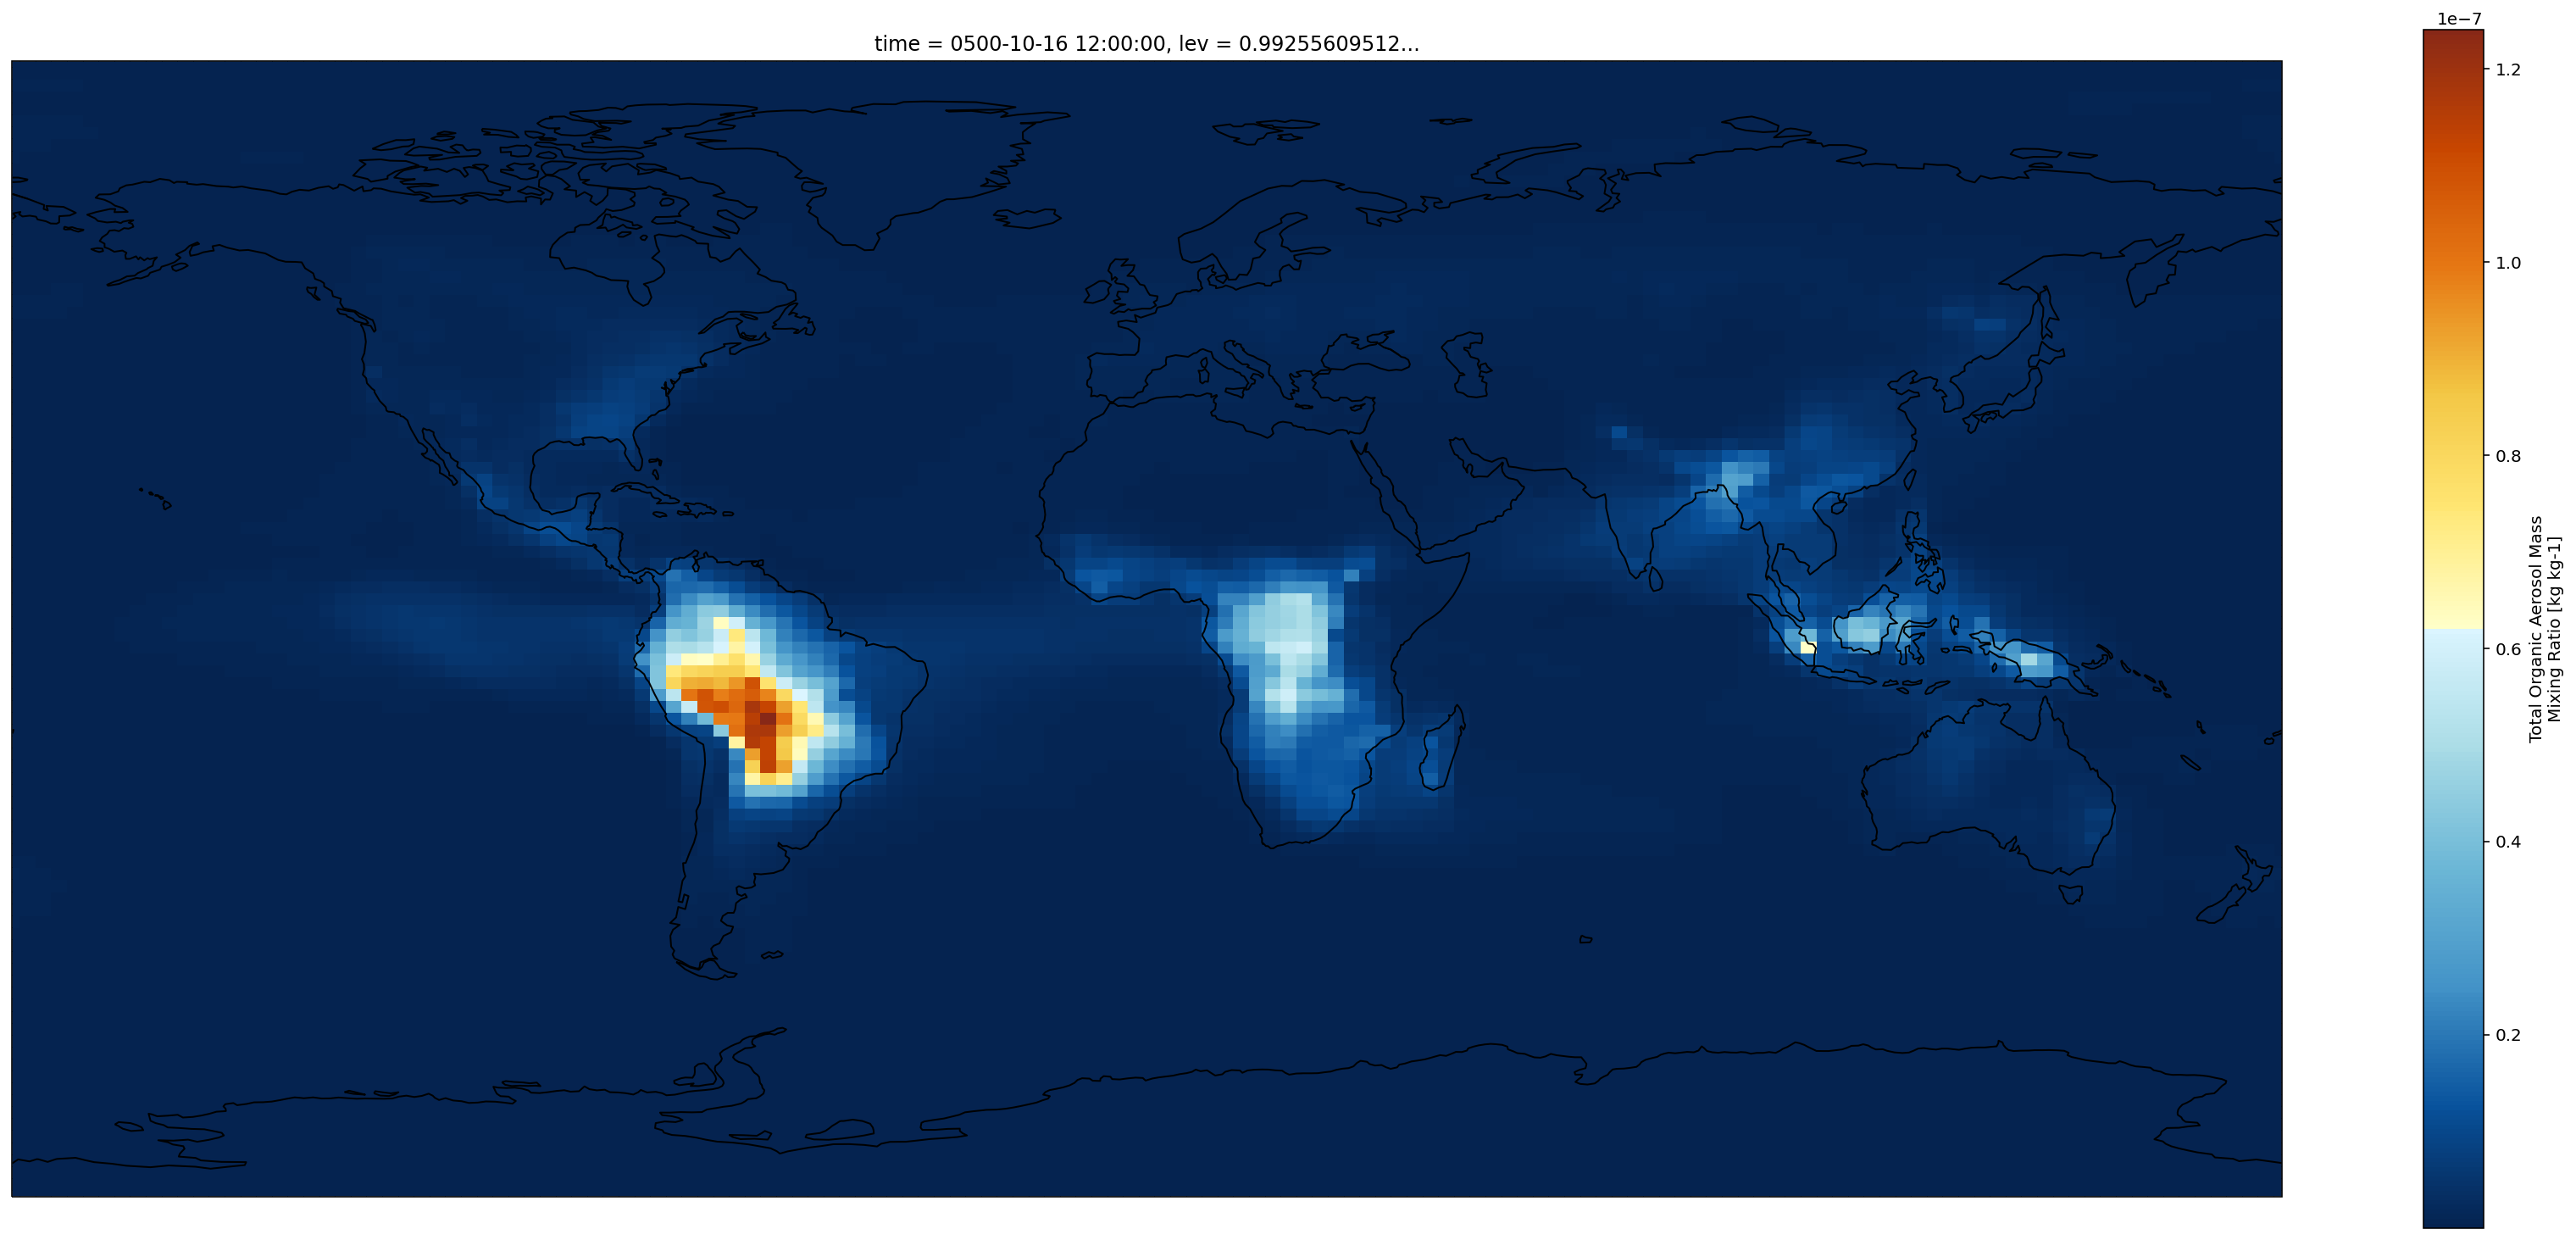

In [7]:
fig = plt.figure(1, figsize=[30,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

ds.mmroa.isel(lev=0).sel(time=cftime.DatetimeNoLeap(500, 10, 16), method='nearest').plot(ax=ax, cmap=cmaps.BlueYellowRed)